In [179]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime

from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *

# Neural Networks
from sklearn.linear_model import LinearRegression

In [181]:
# load movies
movies = load_movies(MOVIES_FILE)
# clean features    
movies = clean_unknowns(movies)
movies = clean_jsons(movies)

movies.head()

,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


In [182]:
movies.shape

(81741, 9)

In [183]:
def drop_nulldates(df):
    return df.dropna(subset=['release_date'])

In [184]:
movies_bo = movies[movies['box_office_revenue'] > 0]
print(f'Movies with box office revenue: {movies_bo.shape[0]}')
print(f'Movies with box office revenue and release date: {drop_nulldates(movies_bo).shape[0]}')
movies_bo = drop_nulldates(movies_bo)

Movies with box office revenue: 8401
Movies with box office revenue and release date: 8327


In [185]:
movies_na = movies[movies['box_office_revenue'].isna()]
print(f'Movies with no box office revenue: {movies_na.shape[0]}')
print(f'Movies with no box office revenue but that have a release date: {drop_nulldates(movies_na).shape[0]}')

Movies with no box office revenue: 73340
Movies with no box office revenue but that have a release date: 66511


In [186]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [187]:
countries = to_1D(movies['countries']).unique()
genres = to_1D(movies['genres']).unique()
languages = to_1D(movies['languages']).unique()
print(f'Countries: {len(countries)}')
print(f'Genres: {len(genres)}')
print(f'Languages: {len(languages)}')

Countries: 148
Genres: 364
Languages: 208


In [200]:
def augment_movies(movies, countries, genres, languages):
    movies_augmented = movies.copy()
    for country in countries:
        movies_augmented[f'country:{country}'] = movies_augmented['countries'].apply(lambda x: 1 if country in x else 0)

    for genre in genres:
        movies_augmented[f'genre:{genre}'] = movies_augmented['genres'].apply(lambda x: 1 if genre in x else 0)

    for language in languages:
        movies_augmented[f'language:{language}'] = movies_augmented['languages'].apply(lambda x: 1 if language in x else 0)

    movies_augmented['release_date'] = movies_augmented['release_date'].apply(lambda x: x.toordinal() if not pd.isna(x) else 0)
    movies_augmented['runtime'] = movies_augmented['runtime'].apply(lambda x: x if not pd.isna(x) else 0)

    movies_augmented = movies_augmented.drop(['wiki_movie_id', 'freebase_movie_id', 'name', 'countries', 'genres', 'languages'], axis=1)

    return movies_augmented

def normalize(movies):
    def normalize_column(column):
        return (column - column.min()) / (column.max() - column.min())

    movies_norm = movies.copy()
    movies_norm['box_office_revenue'] = normalize_column(movies_norm['box_office_revenue'])
    movies_norm['release_date'] = normalize_column(movies_norm['release_date'])
    movies_norm['runtime'] = normalize_column(movies_norm['runtime'])
    
    return movies_norm

def norm_values(feature):
    min = feature.min()
    max = feature.max()
    range = max - min
    return min, range

def denormalize(feature, min, range):
    return feature * range + min

dataset = augment_movies(movies_bo, countries, genres, languages)
dataset = normalize(dataset)
dataset.describe()

,release_date,box_office_revenue,runtime,country:United States of America,country:Norway,country:United Kingdom,country:Germany,country:South Africa,country:Argentina,country:Japan,...,language:Hmong language,language:Osetin Language,language:Deutsch,language:Nahuatl languages,language:Hainanese,language:Chewa language,language:Haryanvi Language,language:Assyrian language,language:Papiamento language,language:Kuna language
count,8327.000000,8327.000000,8327.000000,8327.000000,8327.000000,8327.000000,8327.000000,8327.000000,8327.000000,8327.000000,...,8327.000000,8327.000000,8327.0,8327.000000,8327.0,8327.000000,8327.0,8327.000000,8327.000000,8327.000000
mean,0.815224,0.017345,0.104252,0.831392,0.001561,0.113726,0.053681,0.002642,0.003122,0.024258,...,0.000120,0.000120,0.0,0.000120,0.0,0.000120,0.0,0.000120,0.000120,0.000120
std,0.171106,0.040423,0.025622,0.374428,0.039483,0.317498,0.225400,0.051336,0.055794,0.153860,...,0.010959,0.010959,0.0,0.010959,0.0,0.010959,0.0,0.010959,0.010959,0.010959
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.758901,0.000752,0.092722,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.868877,0.003880,0.101695,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
75%,0.945053,0.014751,0.113659,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000


<AxesSubplot:ylabel='Frequency'>

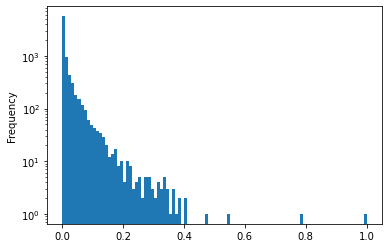

In [201]:
dataset["box_office_revenue"].plot.hist(bins=100, log=True)

In [202]:
train = dataset.sample(frac=0.8, random_state=0)
test = dataset.drop(train.index)

<AxesSubplot:ylabel='Frequency'>

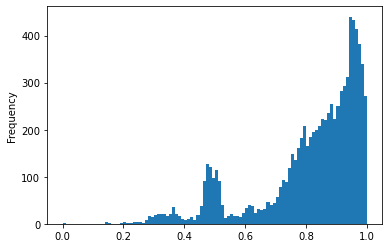

In [203]:
dataset["release_date"].plot.hist(bins=100)

In [204]:
x_train = train.copy()
x_test = test.copy()

y_train = x_train.pop('box_office_revenue')
y_test = x_test.pop('box_office_revenue')

In [193]:
x_train.describe()

,release_date,runtime,country:United States of America,country:Norway,country:United Kingdom,country:Germany,country:South Africa,country:Argentina,country:Japan,country:Turkey,...,language:Hmong language,language:Osetin Language,language:Deutsch,language:Nahuatl languages,language:Hainanese,language:Chewa language,language:Haryanvi Language,language:Assyrian language,language:Papiamento language,language:Kuna language
count,6662.000000,6662.000000,6662.000000,6662.000000,6662.000000,6662.000000,6662.000000,6662.000000,6662.000000,6662.000000,...,6662.000000,6662.000000,6662.0,6662.0,6662.0,6662.000000,6662.0,6662.000000,6662.000000,6662.0
mean,0.815538,0.104268,0.833083,0.001501,0.112879,0.051936,0.002402,0.003603,0.023566,0.003452,...,0.000150,0.000150,0.0,0.0,0.0,0.000150,0.0,0.000150,0.000150,0.0
std,0.170330,0.023891,0.372930,0.038717,0.316469,0.221915,0.048952,0.059917,0.151706,0.058660,...,0.012252,0.012252,0.0,0.0,0.0,0.012252,0.0,0.012252,0.012252,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
25%,0.759031,0.091725,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
50%,0.868759,0.101695,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
75%,0.944330,0.113659,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
max,1.000000,0.570289,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.0,1.000000,1.000000,0.0


In [210]:
y_train

22239    0.001051
11041    0.023528
46743    0.000304
56921    0.003972
65175    0.001992
           ...   
49670    0.000077
20238    0.003201
24194    0.003278
30480    0.000191
67652    0.000730
Name: box_office_revenue, Length: 6662, dtype: float64

In [211]:
y_test

0        0.005032
49       0.012336
140      0.000187
164      0.000123
174      0.003997
           ...   
81518    0.000727
81597    0.000087
81631    0.000964
81634    0.000913
81668    0.004683
Name: box_office_revenue, Length: 1665, dtype: float64

In [205]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)

LinearRegression()

In [206]:
y_pred = linreg.predict(x_test)

In [207]:
def plot_predictions(y_pred, y_test):
    plt.scatter(y_pred, y_test)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [208]:
y_test.min(), y_test.max()

(2.408109790334535e-07, 1.0)

In [209]:
y_pred.min(), y_pred.max()

(-4591485809.166523, 4591485809.167496)